### Spoken Language Processing
В этом задании предлагается обучить классификатор класса возраста по голосу (пример с тем, как это можно сделать для пола см. в семинаре)

Подумайте, как лучше предсказывать возраст (может быть разбить на группы?) и какой лосс использовать

P.S. не забудьте, что если то вы работает в Colab, то вы можете поменять среду выполнения на GPU/TPU!

Вопросы по заданию/материалам: @Nestyme

In [ ]:
!pip3 install timit-utils==0.9.0
!pip3 install torchaudio
! wget https://ndownloader.figshare.com/files/10256148 
!unzip -q 10256148

In [ ]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
_TIMIT_PATH = 'data/lisa/data/timit/raw/TIMIT'

## Задание 1
Загрузите данные для обучения. Для этого:
1. Скачайте датасет TIMIT (см семинар)
2. Соберите пары "голос"  — "класс возраста" также, как на семинаре собирались пары "голос"  — "пол". Аудиодорожки сконвертируйте в мелспектрограммы при помощи `torchaudio либо` `librosa`

P.S. вы можете использовать свою реализацию, а можете предложенную (см следующие ячейки)

In [ ]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm
import torch as t


class timit_dataloader:
    def __init__(self, data_path=_TIMIT_PATH, train_mode=True, age_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train', age_mode=age_mode)
            self.validset = self.create_dataset('valid', age_mode=age_mode)
        self.testset = self.create_dataset('test', age_mode=age_mode)

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode, age_mode=False):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target, age_mode=True))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 25:
            return 0
        if 25 <= age <= 40:
            return 1
        if age > 40:
            return 2

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return t.tensor(spectrogram, dtype=t.float).to(device, non_blocking=True)


class dataloader:
    def __init__(self, spectrograms, targets):
        self.data = list(zip(spectrograms, targets))

    def next_batch(self, batch_size, device):
        indices = np.random.randint(len(self.data), size=batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [line[1] for line in input]

        return self.torch_batch(source, target, device)

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [
                t.tensor(val, dtype=t.float).to(device, non_blocking=True)
                for val in [source, target]
            ]
        )

    @staticmethod
    def padd_sequences(lines, pad_token=0):
        lengths = [len(line) for line in lines]
        max_length = max(lengths)

        return np.array(
            [
                line + [pad_token] * (max_length - lengths[i])
                for i, line in enumerate(lines)
            ]
        )

Простая сверточная сеть, ее можно дотюнить или поменять по желанию

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(Model, self).__init__()

        self.batchnorm = nn.ModuleList([
            nn.BatchNorm2d(128)
            for window_size in window_sizes
        ])

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.dropout = nn.ModuleList([
            nn.Dropout(0.5)
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(128 * len(window_sizes), 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for bn, drop, conv in zip(self.batchnorm, self.dropout, self.convs):
            x2 = F.relu(bn(conv(x)))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = drop(x2)
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
       # probs = torch.softmax(logits, 1)
        return logits.float()

    def loss(self, probs, targets):
        return nn.CrossEntropyLoss()(probs, targets)

In [ ]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

trainset = dataloader(*train)
validset = dataloader(*valid)
testset = dataloader(*test)

100%|██████████| 150/150 [00:17<00:00,  8.35it/s]


In [ ]:
age = [_timit_dataloader.return_age(names) for names in _timit_dataloader.corpus.train.people_names]

(array([178., 137.,  76.,  26.,  29.,   7.,   7.,   1.,   0.,   1.]),
 array([21. , 26.5, 32. , 37.5, 43. , 48.5, 54. , 59.5, 65. , 70.5, 76. ]),
 <a list of 10 Patch objects>)

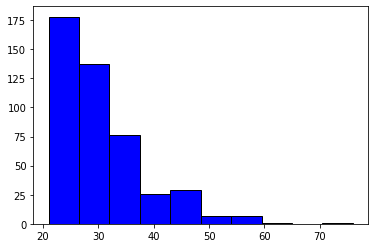

In [ ]:
import matplotlib.pyplot as plt

plt.hist(age, color = 'blue', edgecolor = 'black')


In [ ]:
sum([age.count(i) for i in range(0,26)])

122

In [ ]:
sum([age.count(i) for i in range(26,31)])

172

In [ ]:
sum([age.count(i) for i in range(31,100)])

168

#Задание 2
1. Обучите свой классификатор категории возраста
2. Попробуйте улучшить результат. Можно попробовать усложнить сетку, подвигать границы категорий, поискать новые данные, что угодно, кроме учиться на тесте :)
3. Какой подход оказался самым эффективным? Как думаете, почему?
4. Как считаете, где можно было бы применить такой классификатор в качестве вспомогательной задачи?


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {device} mode')
patience = 500
best_loss = 1000
cnt = 0

using cuda mode


In [ ]:
model = Model()
if device == torch.device('cuda'):
    model.cuda()
else:
    model.cpu()
model.train()

Model(
  (batchnorm): ModuleList(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=[3, 128], stride=(1, 1), padding=(2, 0))
    (1): Conv2d(1, 128, kernel_size=[4, 128], stride=(1, 1), padding=(3, 0))
    (2): Conv2d(1, 128, kernel_size=[5, 128], stride=(1, 1), padding=(4, 0))
  )
  (dropout): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Dropout(p=0.5, inplace=False)
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=384, out_features=3, bias=True)
)

In [ ]:
BATCH_SIZE = 64

optimizer = Adam(
    [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5
)

In [ ]:
from scipy.special import softmax

In [ ]:
import torch as t
for i in range(300):

    optimizer.zero_grad()

    input, target = trainset.next_batch(BATCH_SIZE, device=device)
    out = model(input)
    #print(out)
    loss = model.loss(out, target.long())
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        model.eval()

        with torch.no_grad():
            optimizer.zero_grad()

            input, target = validset.next_batch(BATCH_SIZE, device=device)
            out = model(input)
            valid_loss = model.loss(out, target.long())
            out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
            # print(out, target)
           # out = [1. if tmp > 0.75 else 0.5 if tmp > 0.25 else 0 for tmp in out]
            out = softmax(out).argmax(1)
           #out = out.argmax(1)
            print(out,target)
            print(f'accuracy_score:{accuracy_score(out, target)}')
            print("i {}, valid {}".format(i, valid_loss.item()))
            print("_________")

        model.train()

    if i % 50 == 0 and best_loss > valid_loss.item():
        best_loss = valid_loss.item()
        cnt = 0
    else:
        cnt += 1

    if cnt > patience:
        break
print('training finished')


[1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1] [1. 1. 1. 1. 1. 0. 1. 0. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 2. 2. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 2. 1. 1. 1. 1. 1. 1. 0. 2. 0. 0. 1. 1. 0. 1. 1.]
accuracy_score:0.71875
i 0, valid 2.4750869274139404
_________
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 1 2 1 1 1 2 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1] [2. 1. 0. 1. 0. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 2.
 2. 2. 2. 1. 2. 1. 1. 1. 2. 1. 0. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 0. 1. 2. 2. 1. 1. 1. 2. 1. 0. 1.]
accuracy_score:0.640625
i 10, valid 1.5224565267562866
_________
[1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1] [1. 2. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1.
 0. 1. 1. 0. 1

In [ ]:
input, target = _timit_dataloader.testset
output = model(torch.tensor(input).float().cuda())
test_loss = model.loss(output, torch.tensor(target).long().cuda())
output, target = F.softmax(output).argmax(1), target
print(f'accuracy_score:{accuracy_score(output.cpu(), target)}')


accuracy_score:0.6686666666666666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


## ВЫВОД

> Для улучшения результата я попробовал добавить "набор джентельмена" - BatchNorm + Dropout, мне это дало неплохой прирост.

> Дальше я начал эксперементировать с границами, пробовал балансировку, выше с гистограммой можете видеть разбиение, но мне это не помогло.


> Я решил попробовал менять строгие неравенства и включение одного из возрастов в тот или иной класс мне это помогло значительно поднять accuracy (0.58 -> 0.65 -> 0.66). 

> Классифкация возраста по голосу неплохо бы сочеталась с задачей нашего семинара - классификация пола по голосу, так как детские голоса могут быть схожи с женским.